In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import chardet

In [22]:
#Data Preparation of Climate dataset
climate_data = pd.read_excel('Dataset/archive/Merged_climate_data.xlsx')
climate_data.columns = climate_data.columns.str.replace('-07', '')
climate_data

,code,name,1950,1951,1952,1953,1954,1955,1956,1957,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,SheetName
0,AGO,Angola,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,fd
1,AND,Andorra,12.52,13.23,10.87,12.00,12.39,10.18,13.64,12.21,...,11.38,11.73,9.75,9.27,10.27,10.99,9.85,10.87,9.34,fd
2,ASM,American Samoa (U.S.),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,fd
3,AGO,Angola,45.40,62.05,65.64,84.28,52.09,84.92,86.49,106.08,...,87.80,89.09,91.35,90.15,97.34,87.53,92.94,87.56,100.19,pr
4,AND,Andorra,79.64,111.16,93.81,77.02,87.54,83.76,86.19,85.32,...,86.50,115.51,110.31,86.19,83.41,91.09,124.84,95.41,104.33,pr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,ALB,Albania,86.20,90.25,111.80,74.71,100.59,124.79,115.01,98.20,...,113.45,115.90,116.14,95.40,127.12,96.53,125.68,105.76,95.45,pr
620,DZA,Algeria,5.15,7.24,4.92,6.25,5.42,6.07,5.13,8.44,...,6.15,5.65,6.11,5.88,5.24,4.86,7.42,5.96,4.23,pr
621,AFG,Afghanistan,10.00,10.92,11.05,11.35,11.10,11.94,11.69,9.83,...,11.59,12.83,12.31,12.95,13.74,13.53,13.72,12.96,12.31,tas
622,ALB,Albania,13.19,12.81,12.98,11.92,11.51,12.19,11.40,12.26,...,13.06,13.20,13.15,13.26,13.16,13.13,13.73,13.57,13.37,tas


In [23]:
# Unpivot the DataFrame
climate_data = pd.melt(climate_data, id_vars=['code', 'name', 'SheetName'], var_name='Year', value_name='Value')
climate_data

,code,name,SheetName,Year,Value
0,AGO,Angola,fd,1950,0.00
1,AND,Andorra,fd,1950,12.52
2,ASM,American Samoa (U.S.),fd,1950,0.00
3,AGO,Angola,pr,1950,45.40
4,AND,Andorra,pr,1950,79.64
...,...,...,...,...,...
44299,ALB,Albania,pr,2020,95.45
44300,DZA,Algeria,pr,2020,4.23
44301,AFG,Afghanistan,tas,2020,12.31
44302,ALB,Albania,tas,2020,13.37


In [24]:
climate_data.columns = ['Country_Code', 'Country', 'Climate Variables', 'Year', 'Value']

In [25]:
#Pivot the Climate Variables values as columns
climate_data = climate_data.pivot_table(index=['Country_Code', 'Country', 'Year'], columns='Climate Variables', values='Value')
climate_data.reset_index(inplace=True)
climate_data

Climate Variables,Country_Code,Country,Year,fd,pr,tas
0,ABW,Aruba (Neth.),1950,0.0,87.00,25.89
1,ABW,Aruba (Neth.),1951,0.0,50.20,26.56
2,ABW,Aruba (Neth.),1952,0.0,44.75,26.58
3,ABW,Aruba (Neth.),1953,0.0,44.66,26.59
4,ABW,Aruba (Neth.),1954,0.0,70.32,26.07
...,...,...,...,...,...,...
14763,ZWE,Zimbabwe,2016,0.0,59.72,22.36
14764,ZWE,Zimbabwe,2017,0.0,81.14,21.23
14765,ZWE,Zimbabwe,2018,0.0,56.38,21.93
14766,ZWE,Zimbabwe,2019,0.0,50.78,22.45


In [26]:
climate_data.rename(columns={'fd': 'No of frost days', 'pr': 'Precipitation', 'tas':'Avg temperature'}, inplace=True)

In [27]:
# Data Visualization 
# ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland']
# [Ethiopia, Nigeria, Kenya, India, Cambodia, Indonesia]

def plot_histplot(df, factor, xlabel):
    # Create lists of countries to include in each subplot
    countries_group1 = ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland']
    countries_group2 = ['Ethiopia', 'Nigeria', 'Kenya', 'India', 'Cambodia', 'Indonesia']

    # Create a dictionary to map colors to countries
    country_colors = {
        'New Zealand': 'blue',
        'Denmark': 'red',
        'Argentina': 'green',
        'Uruguay': 'orange',
        'Ireland': 'purple',
        'Ethiopia': 'brown',
        'Nigeria': 'pink',
        'Kenya': 'gray',
        'India': 'cyan',
        'Cambodia': 'magenta',
        'Indonesia': 'lime',
    }

    # Filter the data for the selected countries
    filtered_data = df[df['Country'].isin(countries_group1 + countries_group2)]
    filtered_data = filtered_data[~pd.isna(filtered_data)]

    # Create subplots with shared x-axis limits
    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # Subplot 1 for countries_group1
    axes[0].set_title('Group 1: '+factor)
    for country in countries_group1:
        axes[0].hist(filtered_data[filtered_data['Country'] == country][factor], bins=20, alpha=0.5, label=country, color=country_colors[country])
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Frequency')
    axes[0].legend(loc='upper right')

    # Subplot 2 for countries_group2
    axes[1].set_title('Group 2: '+factor)
    for country in countries_group2:
        axes[1].hist(filtered_data[filtered_data['Country'] == country][factor], bins=20, alpha=0.5, label=country, color=country_colors[country])
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Frequency')
    axes[1].legend(loc='upper left')

    # Set the same x-axis limits for both subplots
#     plt.xlim([min(filtered_data[factor]), max(filtered_data[factor])])

    plt.tight_layout()
    plt.show()


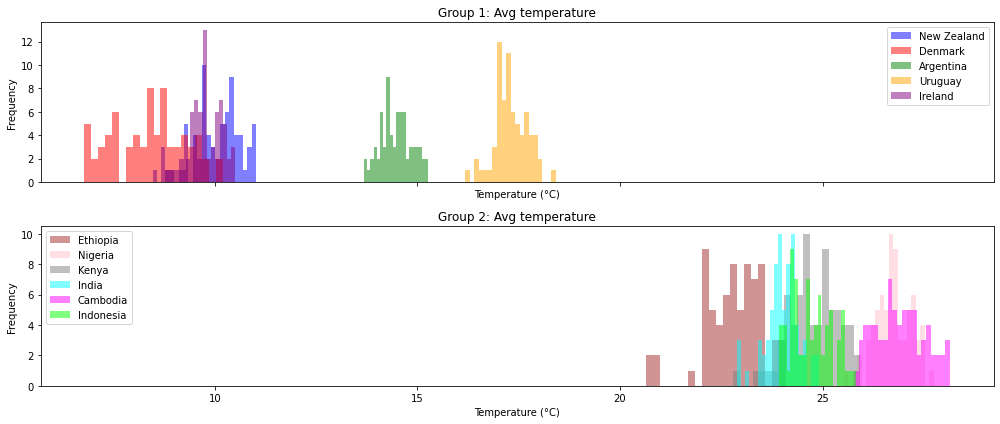

In [28]:
plot_histplot(climate_data, 'Avg temperature', 'Temperature (°C)')

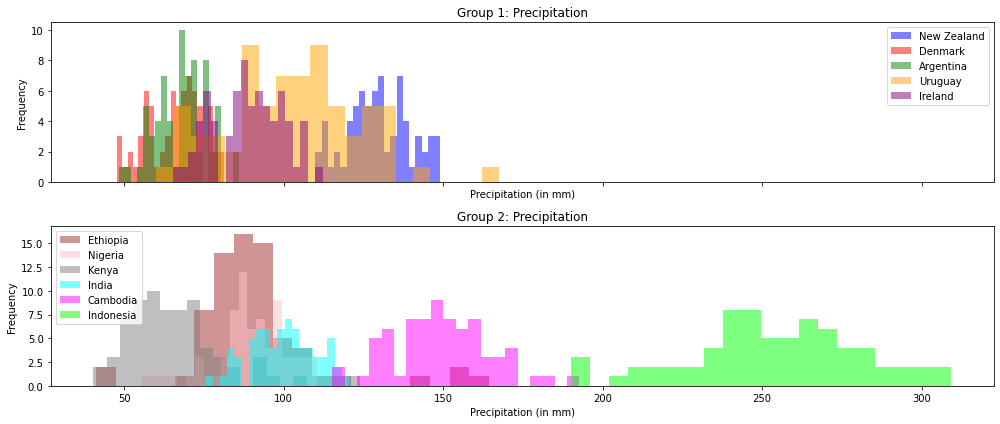

In [29]:
plot_histplot(climate_data, 'Precipitation', 'Precipitation (in mm)')

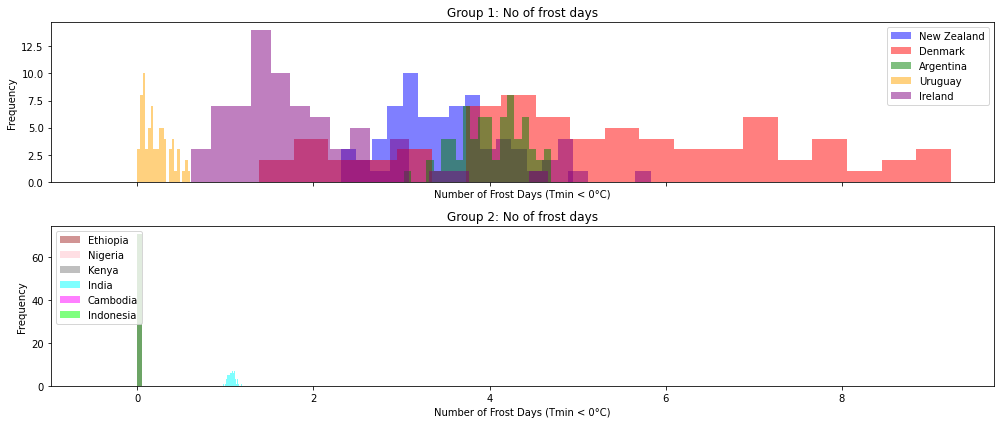

In [30]:
plot_histplot(climate_data, 'No of frost days', 'Number of Frost Days (Tmin < 0°C)')

Observations:


In [31]:
#Import FAOSTAT Credit to Agriculture
faostat_credit = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Credit_To_Agriculture.csv')
faostat_credit.dropna(inplace = True)
faostat_credit = faostat_credit[['Area', 'Year', 'Value']]
#Unit - million USD Item - Credit to Agriculture, Forestry and Fishing
faostat_credit['Value'] = faostat_credit['Value'] * 1000000
faostat_credit.rename(columns={'Area': 'Country', 'Value': 'Credit to Agriculture'}, inplace=True)
faostat_credit

,Country,Year,Credit to Agriculture
0,Afghanistan,2008,1034834.0
1,Afghanistan,2010,12057231.0
2,Afghanistan,2011,12873551.0
3,Afghanistan,2012,16202029.0
4,Afghanistan,2013,20186627.0
...,...,...,...
2725,Zambia,2018,471689849.0
2726,Zambia,2019,453961541.0
2727,Zambia,2020,387963277.0
2728,Zambia,2021,258983069.0


In [32]:
countries_group1 = ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland']
countries_group2 = ['Ethiopia', 'Nigeria', 'Kenya', 'India', 'Cambodia', 'Indonesia']


def plot_lineplot(df, factor, title):

    # Create a figure and axis
    fig, ax3 = plt.subplots(1, figsize=(16, 8))
    
    country_colors = {
        'New Zealand': 'blue',
        'Denmark': 'red',
        'Argentina': 'green',
        'Uruguay': 'orange',
        'Ireland': 'purple',
        'Ethiopia': 'brown',
        'Nigeria': 'pink',
        'Kenya': 'gray',
        'India': 'cyan',
        'Cambodia': 'magenta',
        'Indonesia': 'lime',
    }

    # Filter the data for a specific country
    for i, country in enumerate(countries_group1 + countries_group2):
        country_data = df[df['Country'] == country]

    # Create a line plot for "Use of IMF credit" over the years
        plt.plot(country_data['Year'], country_data[factor], label=country, color=country_colors[country])
    plt.xlabel('Year')
    plt.ylabel(factor)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()



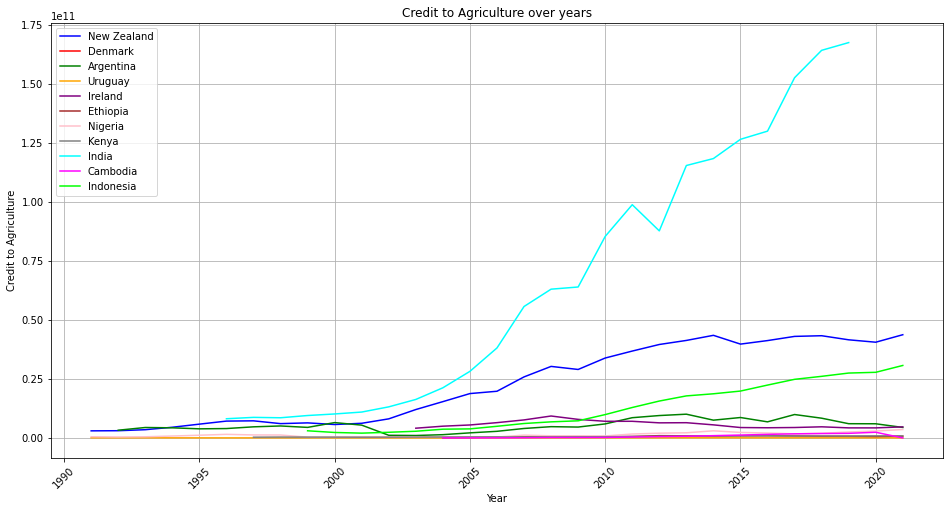

In [20]:
plot_lineplot(faostat_credit, 'Credit to Agriculture', 'Credit to Agriculture over years')

In [39]:
#Import FAOSTAT FDI Inflows to Agriculture
faostat_fdi_inflows = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_FDI_Inflows_to_Agriculture.csv')
faostat_fdi_inflows.dropna(inplace = True)
faostat_fdi_inflows = faostat_fdi_inflows[['Area', 'Element', 'Item', 'Year', 'Unit', 'Value']]
faostat_fdi_inflows = faostat_fdi_inflows[faostat_fdi_inflows['Element'] == 'Value US$']
#Unit - million USD Item - FDI inflows to Agriculture, Forestry and Fishing
faostat_fdi_inflows['Value'] = faostat_fdi_inflows['Value'] * 1000000
#What are the negative values?
faostat_fdi_inflows = faostat_fdi_inflows[['Area', 'Year', 'Value']]
faostat_fdi_inflows.rename(columns={'Area': 'Country', 'Value': 'FDI inflows to Agriculture'}, inplace=True)
faostat_fdi_inflows

,Country,Year,FDI inflows to Agriculture
0,Albania,2004,642888.0
2,Albania,2005,494601.0
4,Albania,2006,2508966.0
6,Albania,2007,2737334.0
8,Albania,2008,-79100597.0
...,...,...,...
3874,Zambia,2017,-13400000.0
3876,Zambia,2018,-147700000.0
3878,Zimbabwe,1993,3532245.0
3880,Zimbabwe,1994,2110031.0


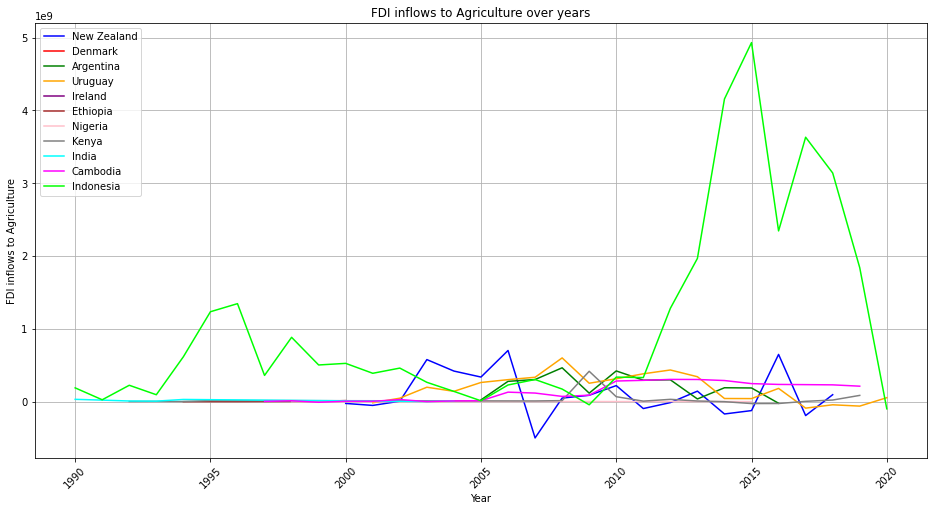

In [40]:
plot_lineplot(faostat_fdi_inflows, 'FDI inflows to Agriculture', 'FDI inflows to Agriculture over years')

In [58]:
#Import FAOSTAT SDG Indicators
faostat_sdg_indicators = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_SDG_Indicators.csv')
faostat_sdg_indicators.dropna(inplace = True)
faostat_sdg_indicators = faostat_sdg_indicators[(faostat_sdg_indicators['Item'] == '2.a.1 Agriculture share of Government Expenditure') |
    (faostat_sdg_indicators['Item'] == '6.4.1 Water Use Efficiency (Agriculture (ISIC4 A01 A0210 A0322))')]

faostat_sdg_indicators

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (SDG),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2001,2001,%,7.31,E,Estimated value,Estimated | FAO Imputed Data | Budgetary Centr...
1,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2002,2002,%,7.33,E,Estimated value,Estimated | FAO Imputed Data | Budgetary Centr...
2,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2003,2003,%,5.33,A,Official figure,Country Data | Data from the International Mon...
3,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2004,2004,%,14.51,A,Official figure,Country Data | Data from the International Mon...
4,SDGB,SDG Indicators,4,Afghanistan,6121,Value,AG_XPD_AGSGB,2.a.1 Agriculture share of Government Expenditure,2005,2005,%,4.68,A,Official figure,Country Data | Data from the International Mon...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18517,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2016,2016,USD/m3,0.04,A,Official figure,Global monitoring data | Food and Agriculture ...
18518,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2017,2017,USD/m3,0.05,A,Official figure,Global monitoring data | Food and Agriculture ...
18519,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2018,2018,USD/m3,0.04,A,Official figure,Global monitoring data | Food and Agriculture ...
18520,SDGB,SDG Indicators,716,Zimbabwe,6178,Value,ER_H2O_WUEYST_AGR,6.4.1 Water Use Efficiency (Agriculture (ISIC4...,2019,2019,USD/m3,0.04,A,Official figure,Global monitoring data | Food and Agriculture ...


In [59]:
faostat_sdg_indicators.rename(columns={'Area': 'Country'}, inplace=True)

In [60]:
faostat_sdg_indicators = faostat_sdg_indicators[['Country', 'Item', 'Year', 'Value']]

#Agriculture share of Government Expenditure - %, Water Use Efficiency (Agriculture) - USD/m3
faostat_sdg_indicators = faostat_sdg_indicators.pivot_table(index=['Country', 'Year'], columns='Item', values='Value')
faostat_sdg_indicators

Item              2.a.1 Agriculture share of Government Expenditure  \
Country     Year                                                      
Afghanistan 2000                                                NaN   
            2001                                               7.31   
            2002                                               7.33   
            2003                                               5.33   
            2004                                              14.51   
...                                                             ...   
Zimbabwe    2016                                                NaN   
            2017                                                NaN   
            2018                                                NaN   
            2019                                                NaN   
            2020                                              12.24   

Item              6.4.1 Water Use Efficiency (Agriculture (ISIC4 A01 A0210 A0322))  
Country     Year                                                                    
Afghanistan 2000                                               0.06                 
            2001                                               0.06                 
            2002                                               0.08                 
            2003                                               0.07                 
            2004                                               0.08                 
...                                                             ...                 
Zimbabwe    2016                                               0.04                 
            2017                                               0.05                 
            2018                                               0.04                 
            2019                                               0.04                 
            2020                                               0.04                 

[4015 rows x 2 columns]

In [62]:
faostat_sdg_indicators.rename(columns={'2.a.1 Agriculture share of Government Expenditure': 'Agriculture share of Government Expenditure'}, inplace=True)
faostat_sdg_indicators.rename(columns={'6.4.1 Water Use Efficiency (Agriculture (ISIC4 A01 A0210 A0322))': 'Water Use Efficiency'}, inplace=True)
faostat_sdg_indicators = faostat_sdg_indicators.reset_index()

faostat_sdg_indicators

Item,Country,Year,Agriculture share of Government Expenditure,Water Use Efficiency
0,Afghanistan,2000,NaN,0.06
1,Afghanistan,2001,7.31,0.06
2,Afghanistan,2002,7.33,0.08
3,Afghanistan,2003,5.33,0.07
4,Afghanistan,2004,14.51,0.08
...,...,...,...,...
4010,Zimbabwe,2016,NaN,0.04
4011,Zimbabwe,2017,NaN,0.05
4012,Zimbabwe,2018,NaN,0.04
4013,Zimbabwe,2019,NaN,0.04


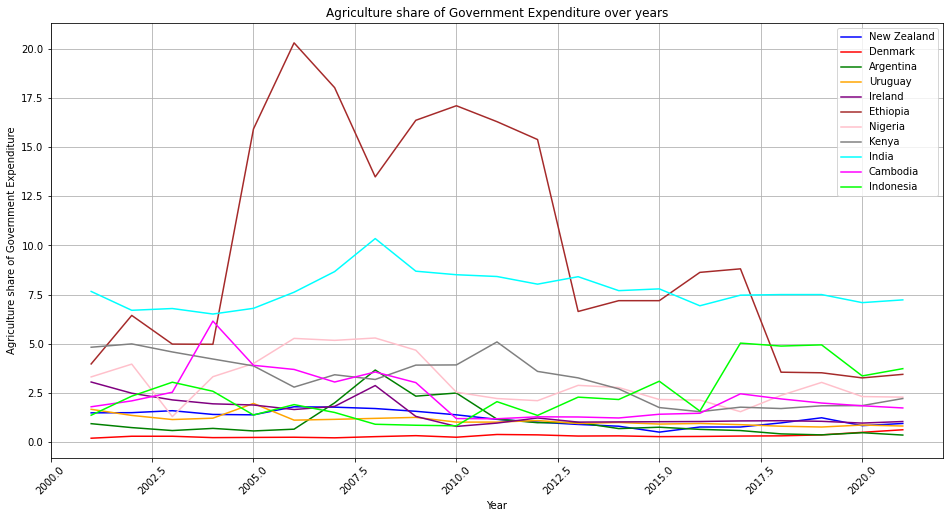

In [63]:
plot_lineplot(faostat_sdg_indicators, 'Agriculture share of Government Expenditure', 'Agriculture share of Government Expenditure over years')

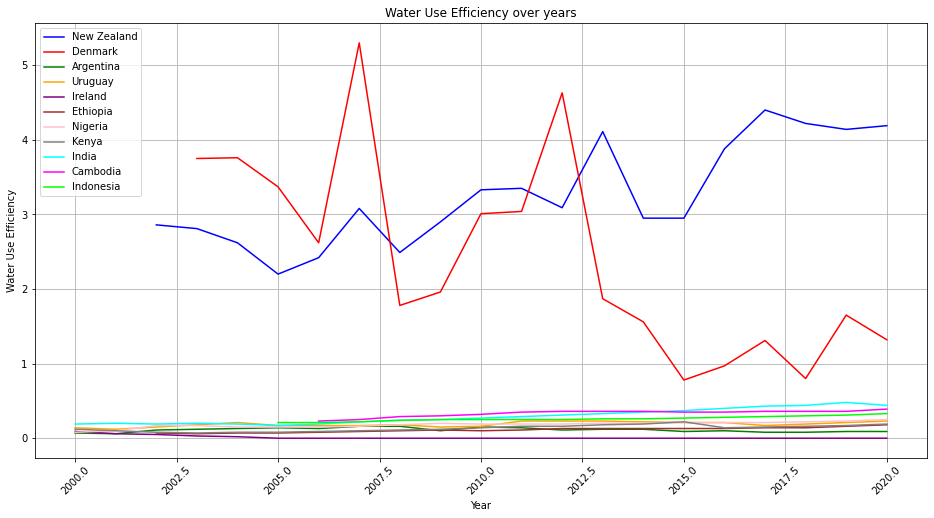

In [64]:
plot_lineplot(faostat_sdg_indicators, 'Water Use Efficiency', 'Water Use Efficiency over years')

In [128]:
#Import World Bank Education Data
world_bank_edu = pd.read_csv('Dataset/archive/World_Bank_Education.csv')
world_bank_edu.dropna(inplace = True)
world_bank_edu.columns = [col.split(' [')[0] for col in world_bank_edu.columns]
world_bank_edu.drop('Series Code', axis=1, inplace=True)
world_bank_edu

,Country Name,Country Code,Series,1960,1961,1962,1963,1964,1965,1966,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, bo...",..,..,..,..,..,..,..,...,65.79363,..,..,..,64.43013,..,..,..,..,..
1,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,51.30789,..,..,..,49.19871,..,..,..,..,..
2,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, ma...",..,..,..,..,..,..,..,...,79.51016,..,..,..,78.91602,..,..,..,..,..
3,Albania,ALB,"Gross enrolment ratio, primary to tertiary, bo...",..,..,..,..,..,..,..,...,88.73256,87.41363,85.23001,84.96134,83.89356,85.01313,..,..,..,..
4,Albania,ALB,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,92.07545,90.64685,88.91327,89.25792,88.64442,90.16838,..,..,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
812,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, ma...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
813,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, bo...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
814,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, fe...",..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


In [129]:
world_bank_edu = pd.melt(world_bank_edu, id_vars=['Country Name', 'Country Code', 'Series'], var_name='Year', value_name='Value')
world_bank_edu

,Country Name,Country Code,Series,Year,Value
0,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, bo...",1960,..
1,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, fe...",1960,..
2,Afghanistan,AFG,"Gross enrolment ratio, primary to tertiary, ma...",1960,..
3,Albania,ALB,"Gross enrolment ratio, primary to tertiary, bo...",1960,..
4,Albania,ALB,"Gross enrolment ratio, primary to tertiary, fe...",1960,..
...,...,...,...,...,...
52219,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, fe...",2023,..
52220,Zambia,ZMB,"Gross enrolment ratio, primary to tertiary, ma...",2023,..
52221,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, bo...",2023,..
52222,Zimbabwe,ZWE,"Gross enrolment ratio, primary to tertiary, fe...",2023,..


In [130]:
# world_bank_edu.replace('..', 0.0, inplace=True) #Imputation?
world_bank_edu['Value'] = world_bank_edu['Value'].replace('..', pd.NA)

# Drop rows where 'Value' is NaN
world_bank_edu = world_bank_edu.dropna(subset=['Value'])

In [131]:
world_bank_edu = world_bank_edu.pivot_table(index=['Country Name', 'Country Code', 'Year'], columns='Series', values='Value')
world_bank_edu.reset_index(inplace=True)
world_bank_edu.rename(columns={'Country Name': 'Country'}, inplace=True)
world_bank_edu.drop('Country Code', axis=1, inplace=True)
world_bank_edu

Series,Country,Year,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)"
0,Afghanistan,1970,16.05820,4.50856,27.41987
1,Afghanistan,1971,16.86606,NaN,NaN
2,Afghanistan,1972,17.40084,4.74242,29.74823
3,Afghanistan,1973,17.80448,5.07726,30.16882
4,Afghanistan,1974,18.09427,5.11067,30.66925
...,...,...,...,...,...
5895,Zimbabwe,2001,62.81822,60.43868,65.22950
5896,Zimbabwe,2002,59.85826,57.56935,62.19583
5897,Zimbabwe,2003,57.87850,55.73510,60.08197
5898,Zimbabwe,2012,66.51386,64.46115,68.64404


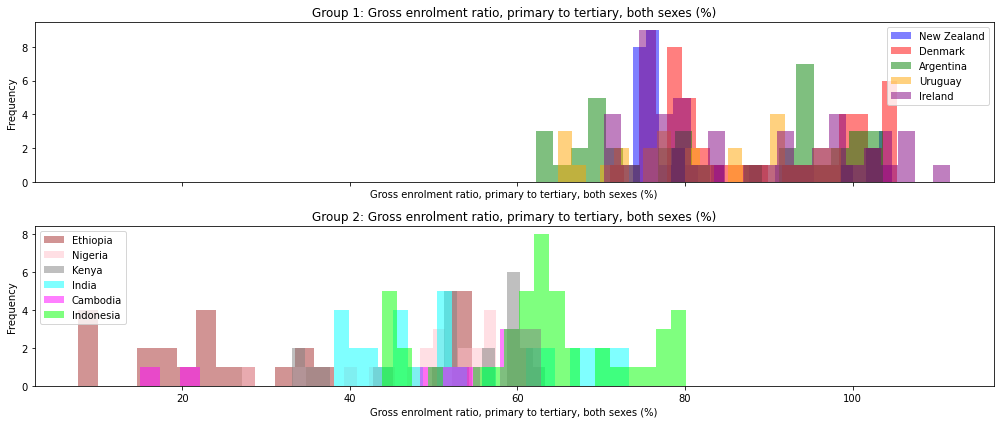

In [25]:
plot_histplot(world_bank_edu, 'Gross enrolment ratio, primary to tertiary, both sexes (%)', 'Gross enrolment ratio, primary to tertiary, both sexes (%)')

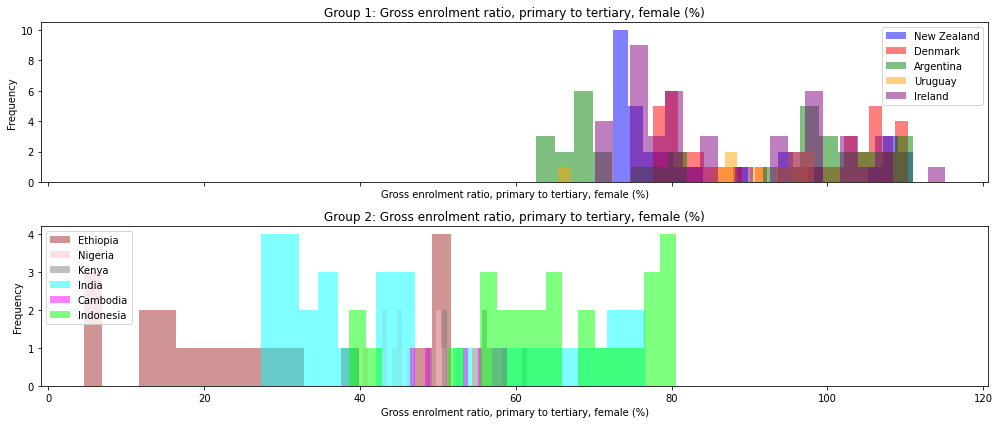

In [26]:
plot_histplot(world_bank_edu, 'Gross enrolment ratio, primary to tertiary, female (%)', 'Gross enrolment ratio, primary to tertiary, female (%)')

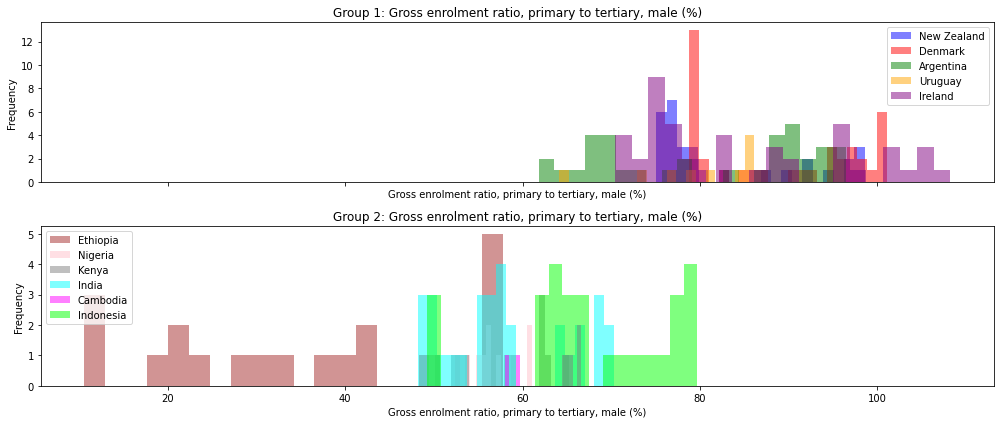

In [27]:
plot_histplot(world_bank_edu, 'Gross enrolment ratio, primary to tertiary, male (%)', 'Gross enrolment ratio, primary to tertiary, male (%)')

In [144]:
#GINI Index
world_GINI_index = pd.read_csv('Dataset/archive/economic-inequality-gini-index.csv')
world_GINI_index = world_GINI_index.rename(columns={'Entity': 'Country Name'})
world_GINI_index.rename(columns={'Country Name': 'Country'}, inplace=True)
world_GINI_index.drop('Code', axis=1, inplace=True)

world_GINI_index

,Country,Year,Gini coefficient
0,Albania,1996,0.270103
1,Albania,2002,0.317390
2,Albania,2005,0.305957
3,Albania,2008,0.299847
4,Albania,2012,0.289605
...,...,...,...
2120,Zambia,2010,0.556215
2121,Zambia,2015,0.571361
2122,Zimbabwe,2011,0.431536
2123,Zimbabwe,2017,0.443371


In [72]:
world_GINI_Kenya = world_GINI_index[world_GINI_index['Country'] == 'Kenya']
world_GINI_Kenya

,Country,Year,Gini coefficient
1127,Kenya,1992,0.574610
1128,Kenya,1994,0.431086
1129,Kenya,1997,0.449831
1130,Kenya,2005,0.464529
1131,Kenya,2015,0.407758


In [73]:
world_GINI_India = world_GINI_index[world_GINI_index['Country'] == 'India']
world_GINI_India

,Country,Year,Gini coefficient
883,India,1977,0.333366
884,India,1983,0.321010
885,India,1987,0.325742
886,India,1993,0.316962
887,India,2004,0.344063
888,India,2009,0.353803
889,India,2011,0.357126
890,India,2015,0.347064
891,India,2016,0.347732
892,India,2017,0.359430


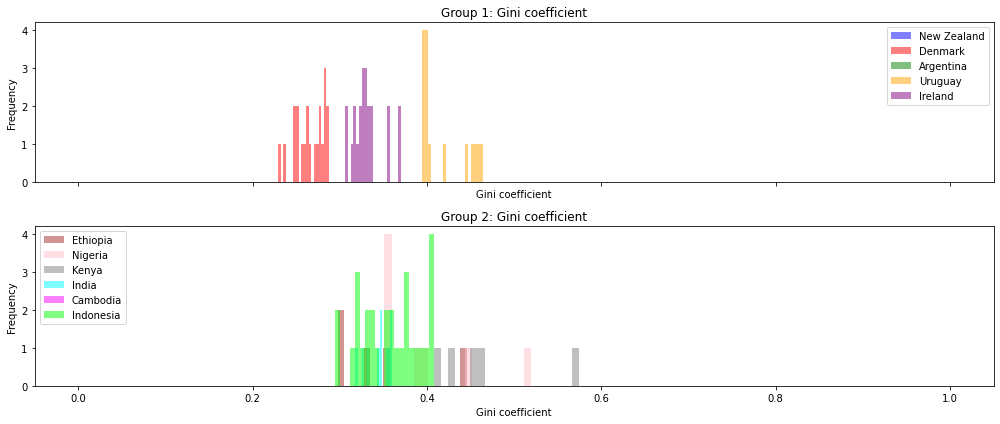

In [145]:
plot_histplot(world_GINI_index, 'Gini coefficient', 'Gini coefficient')

In [38]:
world_GINI_index_2007 = world_GINI_index.loc[world_GINI_index['Year'] <= 2007]

In [72]:
#Land data
agri_land_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Land_Use.csv')
#Unit - 1000 ha
agri_land_data = agri_land_data[['Area', 'Year', 'Value']]
agri_land_data.rename(columns={'Area': 'Country', 'Value':'Area'}, inplace=True)

agri_land_data

,Country,Year,Area
0,Afghanistan,1961,37750.0
1,Afghanistan,1962,37800.0
2,Afghanistan,1963,37850.0
3,Afghanistan,1964,37905.0
4,Afghanistan,1965,37910.0
...,...,...,...
13045,Zimbabwe,2017,16200.0
13046,Zimbabwe,2018,16200.0
13047,Zimbabwe,2019,16200.0
13048,Zimbabwe,2020,16200.0


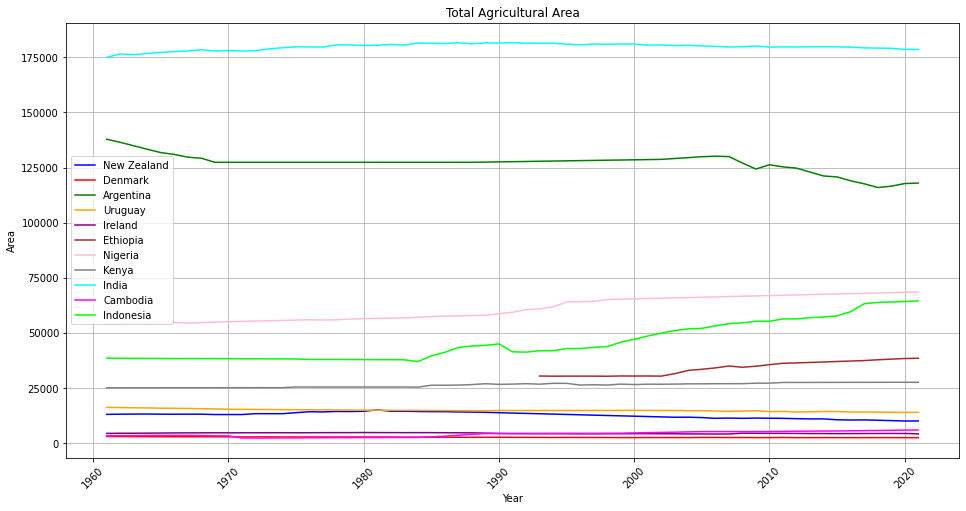

In [73]:


plot_lineplot(agri_land_data, 'Area', 'Total Agricultural Area')

In [135]:
# Year varies from 1961 to 2021
# Unit kg/pc
#'Use per area of cropland', 'Use per capita'
# Estimated value
world_fertilizer_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Fertilizers_By_Nutrient.csv') 
world_fertilizer_data = world_fertilizer_data[world_fertilizer_data['Element']=='Use per capita']
world_fertilizer_data = world_fertilizer_data[['Area', 'Year', 'Item', 'Value']]
grouped_fertilizer_df = world_fertilizer_data.groupby(['Area', 'Year', 'Item'])['Value'].sum().reset_index()
pivot_df = grouped_fertilizer_df.pivot_table(index=['Area', 'Year'], columns='Item', values='Value', fill_value=0).reset_index()
pivot_df['Sum'] =  pivot_df['Nutrient nitrogen N (total)'] + pivot_df['Nutrient phosphate P2O5 (total)'] + pivot_df['Nutrient potash K2O (total)']
fertilizer_data = pivot_df[['Area', 'Year', 'Sum']]
fertilizer_data.columns = ['Country', 'Year', 'Fertilizer Use Per Capita']
fertilizer_data

,Country,Year,Fertilizer Use Per Capita
0,Afghanistan,1961,0.12
1,Afghanistan,1962,0.12
2,Afghanistan,1963,0.12
3,Afghanistan,1964,0.12
4,Afghanistan,1965,0.11
...,...,...,...
10279,Zimbabwe,2017,9.93
10280,Zimbabwe,2018,8.82
10281,Zimbabwe,2019,8.64
10282,Zimbabwe,2020,6.64


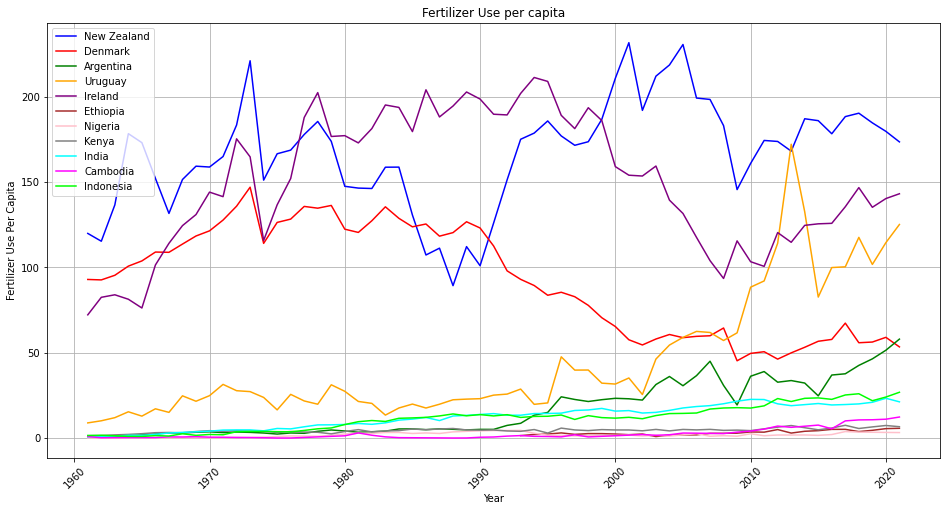

In [136]:
# countries_group1 = ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland']
# countries_group2 = ['Ethiopia', 'Nigeria', 'Kenya', 'India', 'Cambodia', 'Indonesia']

plot_lineplot(fertilizer_data, 'Fertilizer Use Per Capita', 'Fertilizer Use per capita')

"2011 PPP$" in FAO data, means that the values have been adjusted to a common standard (2011) to facilitate cross-country comparisons. This is important in agricultural and economic analyses to account for differences in the cost of living and inflation rates between countries.

In [95]:
#Combine all datasets with the FAO Agriculture data
prod_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Agricultural_Production.csv')
#Unit 1000 USD
prod_data = prod_data[['Area', 'Year', 'Value']]
prod_data.columns = ['Country', 'Year', 'Gross_Production']

prod_data

,Country,Year,Gross_Production
0,Albania,1993,931920
1,Albania,1994,937440
2,Albania,1995,790407
3,Albania,1996,828691
4,Albania,1997,740817
...,...,...,...
4583,Zimbabwe,2014,1233297
4584,Zimbabwe,2015,3155327
4585,Zimbabwe,2016,3540996
4586,Zimbabwe,2017,3624101


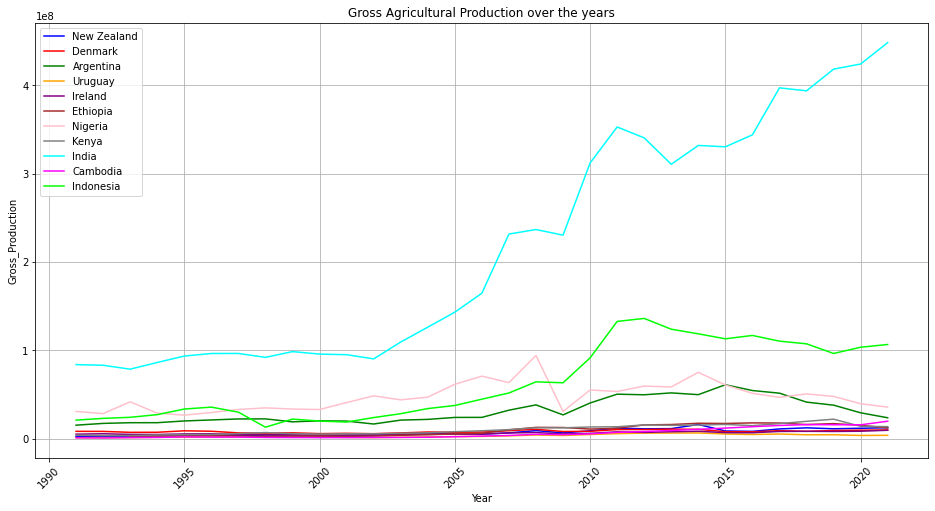

In [96]:
plot_lineplot(prod_data, 'Gross_Production', 'Gross Agricultural Production over the years')

In [123]:
#World GDP Data
world_gdp_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_GDP.csv')
# world_gdp_data = world_gdp_data[world_gdp_data['Element'] == 'Value US$']
world_gdp_data = world_gdp_data[['Area', 'Element', 'Year', 'Value']]
pivot_gdp_df = world_gdp_data.pivot_table(index=['Area', 'Year'], columns='Element', values='Value').reset_index()
#GDP unit is in 1000 USD
pivot_gdp_df['Value US$'] = pivot_gdp_df['Value US$']*1000
world_gdp_data = pivot_gdp_df
world_gdp_data.rename(columns={'Area': 'Country', 'Value US$':'GDP(1000 USD)', 'Value US$ per capita':'GDP per capita'}, inplace=True)

world_gdp_data

Element,Country,Year,GDP(1000 USD),GDP per capita
0,Afghanistan,1970,1.731436e+06,161.019274
1,Afghanistan,1971,1.812838e+06,164.566181
2,Afghanistan,1972,1.647900e+06,146.003034
3,Afghanistan,1973,1.702716e+06,147.099044
4,Afghanistan,1974,2.061729e+06,173.694213
...,...,...,...,...
10692,Zimbabwe,2018,2.364527e+07,1570.886029
10693,Zimbabwe,2019,2.259452e+07,1471.513983
10694,Zimbabwe,2020,2.166475e+07,1382.591426
10695,Zimbabwe,2021,2.411815e+07,1507.994790


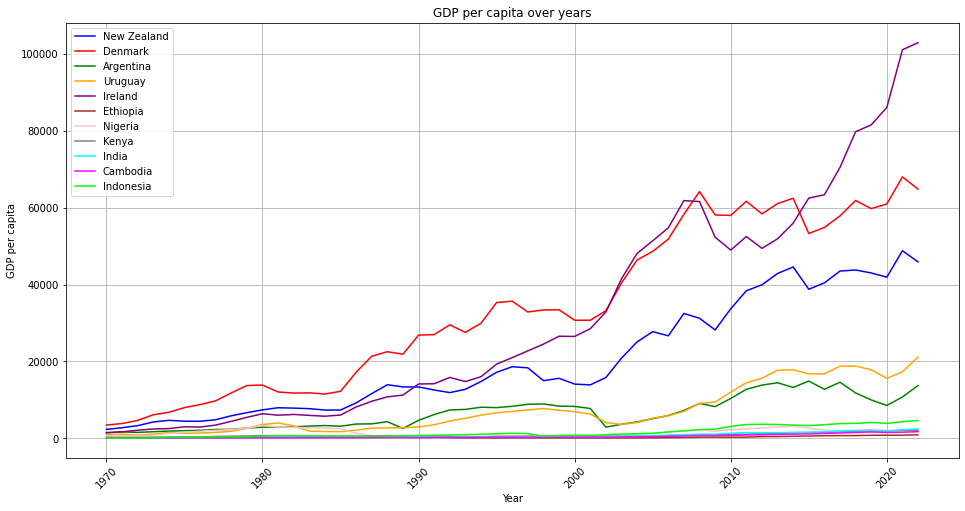

In [124]:
#Data Visualization of GDP
# countries_group1 = ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland']
# countries_group2 = ['Ethiopia', 'Nigeria', 'Kenya', 'India', 'Cambodia', 'Indonesia']

plot_lineplot(world_gdp_data, 'GDP per capita', 'GDP per capita over years')

In [113]:
#Population data
population_data = pd.read_csv('Dataset/archive/FAOSTAT/FAOSTAT_Population.csv')
population_data = population_data[['Area', 'Year', 'Unit', 'Value']]

population_data['Value'] = population_data['Value'] * 1000
population_data.drop(['Unit'], axis = 1, inplace=True)
population_data.rename(columns={'Area': 'Country', 'Value':'Population'}, inplace=True)

population_data

,Country,Year,Population
0,Afghanistan,1950,7480461.0
1,Afghanistan,1951,7571537.0
2,Afghanistan,1952,7667533.0
3,Afghanistan,1953,7764546.0
4,Afghanistan,1954,7864285.0
...,...,...,...
15538,Zimbabwe,2017,14751101.0
15539,Zimbabwe,2018,15052184.0
15540,Zimbabwe,2019,15354608.0
15541,Zimbabwe,2020,15669666.0


In [50]:
#GHI data
sheet_index = 2
GHI_data = pd.read_excel('Dataset/archive/Global_Hunger_Index_Scores.xlsx', sheet_name=sheet_index)
GHI_data.columns = GHI_data.iloc[1]
GHI_data = GHI_data.iloc[2:-3] #Delete the first and bottom 2 rows
GHI_data.columns = ['Country', '2000', '2007', '2014', '2022', 'Absolute change since 2014', '% change since 2014']
GHI_data = GHI_data[['Country', '2000', '2007', '2014', '2022']]
#The dataset contains non-numeric values like '-'
# GHI_2007['2007'] = pd.to_numeric(GHI_2007['2007'], errors='coerce')
# GHI_2007.dropna(inplace = True)
GHI_data = pd.melt(GHI_data, id_vars=['Country'], var_name='Year', value_name='GHI')
GHI_data

,Country,Year,GHI
0,Afghanistan,2000,50.3
1,Albania,2000,20.7
2,Algeria,2000,14.5
3,Angola,2000,64.9
4,Argentina,2000,6.6
...,...,...,...
539,Venezuela (Boliv. Rep. of),2022,19.9
540,Viet Nam,2022,11.9
541,Yemen,2022,45.1
542,Zambia,2022,29.3


In [143]:
#Merge with GDP Data
agri_data = pd.merge(prod_data, world_gdp_data, how='inner', on=['Country','Year'])
#Climate data
climate_data['Year']=climate_data['Year'].astype(pd.Int64Dtype())
agri_data = pd.merge(agri_data, climate_data, how='inner', on=['Country','Year']) 
#Socio-economic data

# agri_data = pd.merge(agri_data, world_bank_data, how='inner', on=['Country','Year']) 

world_bank_edu['Year']=world_bank_edu['Year'].astype(pd.Int64Dtype())
agri_data = pd.merge(agri_data, world_bank_edu, how='inner', on=['Country','Year'])

agri_land_data['Year']=agri_land_data['Year'].astype(pd.Int64Dtype())
agri_data = pd.merge(agri_data, agri_land_data, how='inner', on=['Country','Year'])

agri_data = pd.merge(agri_data, population_data, how='inner', on=['Country','Year'])

agri_data = pd.merge(agri_data, fertilizer_data, how='inner', on=['Country','Year'])

agri_data = pd.merge(agri_data, faostat_credit, how='left', on=['Country','Year'])

agri_data = pd.merge(agri_data, faostat_fdi_inflows, how='left', on=['Country','Year'])

agri_data = pd.merge(agri_data, faostat_sdg_indicators, how='left', on=['Country','Year'])

agri_data

,Country,Year,Gross_Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency
0,Albania,1993,931920,1.700439e+06,515.173587,ALB,6.29,90.18,12.14,61.81223,62.71862,60.94200,1126.0,3300711.0,5.42,NaN,NaN,NaN,NaN
1,Albania,1994,937440,1.880951e+06,571.023495,ALB,3.95,76.69,13.21,62.06585,61.85745,62.26813,1126.0,3293999.0,4.48,NaN,NaN,NaN,NaN
2,Albania,1995,790407,2.392765e+06,728.532187,ALB,5.08,116.03,11.81,62.87973,61.83495,63.89844,1127.0,3284364.0,3.34,NaN,NaN,NaN,NaN
3,Albania,1996,828691,3.199642e+06,978.085686,ALB,4.80,123.96,11.91,63.40557,62.58842,64.19750,1131.0,3271331.0,1.99,NaN,NaN,NaN,NaN
4,Albania,1997,740817,2.224654e+06,683.726604,ALB,5.38,81.00,12.12,65.17871,64.14992,66.18734,1135.0,3253719.0,1.60,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Uruguay,2015,5252901,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,NaN,NaN,14467.6,3402818.0,82.61,48841471.0,42023232.0,0.91,0.21
1943,Uruguay,2016,4674983,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,NaN,NaN,14265.3,3413766.0,99.90,45199938.0,182055671.0,0.94,0.21
1944,Uruguay,2017,5233514,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,NaN,NaN,14222.9,3422200.0,100.32,45811604.0,-88928363.0,0.88,0.17
1945,Zimbabwe,2012,982091,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,64.46115,68.64404,16200.0,13265331.0,5.50,NaN,NaN,5.67,0.04


In [146]:
#Merge with GINI Index
agri_data = pd.merge(agri_data, world_GINI_index, how='left', on=['Country','Year'])
agri_data

,Country,Year,Gross_Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient
0,Albania,1993,931920,1.700439e+06,515.173587,ALB,6.29,90.18,12.14,61.81223,62.71862,60.94200,1126.0,3300711.0,5.42,NaN,NaN,NaN,NaN,NaN
1,Albania,1994,937440,1.880951e+06,571.023495,ALB,3.95,76.69,13.21,62.06585,61.85745,62.26813,1126.0,3293999.0,4.48,NaN,NaN,NaN,NaN,NaN
2,Albania,1995,790407,2.392765e+06,728.532187,ALB,5.08,116.03,11.81,62.87973,61.83495,63.89844,1127.0,3284364.0,3.34,NaN,NaN,NaN,NaN,NaN
3,Albania,1996,828691,3.199642e+06,978.085686,ALB,4.80,123.96,11.91,63.40557,62.58842,64.19750,1131.0,3271331.0,1.99,NaN,NaN,NaN,NaN,0.270103
4,Albania,1997,740817,2.224654e+06,683.726604,ALB,5.38,81.00,12.12,65.17871,64.14992,66.18734,1135.0,3253719.0,1.60,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Uruguay,2015,5252901,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,NaN,NaN,14467.6,3402818.0,82.61,48841471.0,42023232.0,0.91,0.21,0.401288
1943,Uruguay,2016,4674983,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,NaN,NaN,14265.3,3413766.0,99.90,45199938.0,182055671.0,0.94,0.21,0.396955
1944,Uruguay,2017,5233514,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,NaN,NaN,14222.9,3422200.0,100.32,45811604.0,-88928363.0,0.88,0.17,0.394645
1945,Zimbabwe,2012,982091,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,64.46115,68.64404,16200.0,13265331.0,5.50,NaN,NaN,5.67,0.04,NaN


In [150]:
agri_data['Gross_Prod_Per_Capita'] = (agri_data['Gross_Production']/agri_data['Population'])*1000
agri_data

,Country,Year,Gross_Production,GDP(1000 USD),GDP per capita,Country_Code,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)",...,"Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient,Gross_Prod_Per_Capita
0,Albania,1993,931920,1.700439e+06,515.173587,ALB,6.29,90.18,12.14,61.81223,...,60.94200,1126.0,3300711.0,5.42,NaN,NaN,NaN,NaN,NaN,282.339169
1,Albania,1994,937440,1.880951e+06,571.023495,ALB,3.95,76.69,13.21,62.06585,...,62.26813,1126.0,3293999.0,4.48,NaN,NaN,NaN,NaN,NaN,284.590250
2,Albania,1995,790407,2.392765e+06,728.532187,ALB,5.08,116.03,11.81,62.87973,...,63.89844,1127.0,3284364.0,3.34,NaN,NaN,NaN,NaN,NaN,240.657552
3,Albania,1996,828691,3.199642e+06,978.085686,ALB,4.80,123.96,11.91,63.40557,...,64.19750,1131.0,3271331.0,1.99,NaN,NaN,NaN,NaN,0.270103,253.319215
4,Albania,1997,740817,2.224654e+06,683.726604,ALB,5.38,81.00,12.12,65.17871,...,66.18734,1135.0,3253719.0,1.60,NaN,NaN,NaN,NaN,NaN,227.683153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,Uruguay,2015,5252901,5.708076e+07,16774.555410,URY,0.20,103.82,17.88,95.61326,...,NaN,14467.6,3402818.0,82.61,48841471.0,42023232.0,0.91,0.21,0.401288,1543.691435
1943,Uruguay,2016,4674983,5.723665e+07,16766.425259,URY,0.05,111.88,17.25,97.38798,...,NaN,14265.3,3413766.0,99.90,45199938.0,182055671.0,0.94,0.21,0.396955,1369.450337
1944,Uruguay,2017,5233514,6.423397e+07,18769.787523,URY,0.08,113.84,18.42,98.66813,...,NaN,14222.9,3422200.0,100.32,45811604.0,-88928363.0,0.88,0.17,0.394645,1529.283502
1945,Zimbabwe,2012,982091,1.711485e+07,1290.193956,ZWE,0.01,50.65,21.80,66.51386,...,68.64404,16200.0,13265331.0,5.50,NaN,NaN,5.67,0.04,NaN,74.034413


In [153]:
#Missing value counts
nan_counts = agri_data.isna().sum()
nan_counts

Country                                                          0
Year                                                             0
Gross_Production                                                 0
GDP(1000 USD)                                                    0
GDP per capita                                                   0
Country_Code                                                     0
No of frost days                                                 0
Precipitation                                                    0
Avg temperature                                                  0
Gross enrolment ratio, primary to tertiary, both sexes (%)       0
Gross enrolment ratio, primary to tertiary, female (%)         197
Gross enrolment ratio, primary to tertiary, male (%)           197
Area                                                             0
Population                                                       0
Fertilizer Use Per Capita                                     

In [152]:
#Before Imputation
agri_data.corr()

,Year,Gross_Production,GDP(1000 USD),GDP per capita,No of frost days,Precipitation,Avg temperature,"Gross enrolment ratio, primary to tertiary, both sexes (%)","Gross enrolment ratio, primary to tertiary, female (%)","Gross enrolment ratio, primary to tertiary, male (%)",Area,Population,Fertilizer Use Per Capita,Credit to Agriculture,FDI inflows to Agriculture,Agriculture share of Government Expenditure,Water Use Efficiency,Gini coefficient,Gross_Prod_Per_Capita
Year,1.000000,0.104469,0.153844,0.249619,-0.064144,0.045603,0.075120,0.329187,0.299891,0.285448,0.012611,0.043156,-0.006160,0.126770,0.101271,-0.114400,0.142202,-0.125510,0.215300
Gross_Production,0.104469,1.000000,0.889328,-0.038510,0.113936,-0.011856,-0.072539,-0.008382,-0.008369,-0.006694,0.682414,0.804156,0.044720,0.801393,0.424768,0.098275,-0.059543,0.059272,0.108806
GDP(1000 USD),0.153844,0.889328,1.000000,0.151348,0.141186,-0.037162,-0.143949,0.140412,0.126054,0.141108,0.586150,0.636251,0.115350,0.834223,0.100616,-0.182761,0.124079,-0.005834,0.232018
GDP per capita,0.249619,-0.038510,0.151348,1.000000,0.271545,-0.058530,-0.363462,0.534184,0.538633,0.507055,-0.104606,-0.113210,0.316797,0.282020,-0.087557,-0.381461,0.381575,-0.417144,0.510003
No of frost days,-0.064144,0.113936,0.141186,0.271545,1.000000,-0.172952,-0.914667,0.349611,0.371312,0.352398,0.169132,0.067913,0.213672,0.071682,-0.089224,-0.146904,0.017298,-0.529288,0.165353
Precipitation,0.045603,-0.011856,-0.037162,-0.058530,-0.172952,1.000000,0.204210,0.005922,0.008697,0.029688,-0.123760,0.021924,0.009657,-0.004955,0.260452,0.092090,0.153127,0.478420,-0.019483
Avg temperature,0.075120,-0.072539,-0.143949,-0.363462,-0.914667,0.204210,1.000000,-0.506195,-0.515419,-0.508206,-0.093570,-0.002672,-0.382385,-0.135950,0.133226,0.256259,-0.065418,0.629607,-0.369388
"Gross enrolment ratio, primary to tertiary, both sexes (%)",0.329187,-0.008382,0.140412,0.534184,0.349611,0.005922,-0.506195,1.000000,0.988351,0.985952,-0.009475,-0.114419,0.459640,0.197214,-0.042341,-0.483441,0.238036,-0.388279,0.572879
"Gross enrolment ratio, primary to tertiary, female (%)",0.299891,-0.008369,0.126054,0.538633,0.371312,0.008697,-0.515419,0.988351,1.000000,0.949670,0.000804,-0.106529,0.450643,0.197157,-0.050854,-0.494019,0.236986,-0.401615,0.539243
"Gross enrolment ratio, primary to tertiary, male (%)",0.285448,-0.006694,0.141108,0.507055,0.352398,0.029688,-0.508206,0.985952,0.949670,1.000000,0.024126,-0.097644,0.449636,0.210710,-0.040311,-0.480353,0.212080,-0.384180,0.576056


In [154]:
overall_corr_with_gross_prod = agri_data.corr()["Gross_Prod_Per_Capita"]
for column, correlation in overall_corr_with_gross_prod.items():
        if correlation >= 0.3 or correlation <= -0.3:
            print(f" Column: {column}, Correlation: {correlation}")

 Column: GDP per capita, Correlation: 0.5100032484148441
 Column: Avg temperature, Correlation: -0.3693879100330066
 Column: Gross enrolment ratio, primary to tertiary, both sexes (%), Correlation: 0.5728787712585344
 Column: Gross enrolment ratio, primary to tertiary, female (%), Correlation: 0.5392432419083187
 Column: Gross enrolment ratio, primary to tertiary, male (%), Correlation: 0.5760563552538794
 Column: Fertilizer Use Per Capita, Correlation: 0.6745498613585887
 Column: Agriculture share of Government Expenditure, Correlation: -0.33813306164042445
 Column: Gross_Prod_Per_Capita, Correlation: 1.0


In [60]:
#Pandas Profiling - Takes minutes to run
#https://www.analyticsvidhya.com/blog/2021/06/generate-reports-using-pandas-profiling-deploy-using-streamlit/
# profile = ProfileReport(agri_data, title='Pandas Profiling Report', explorative=True)

# # Generate the report
# profile.to_file("docs/report.html")

In [155]:
#Checking correlation coefficients of well-producing developed countries
column_count = {}
countries_group1 = ['New Zealand', 'Denmark', 'Argentina', 'Uruguay', 'Ireland', 'Canada', 'Australia', 'United States of America', 'Belarus', 'Netherlands']

correlation_threshold = 0.3
for country in countries_group1:
    agri_country = agri_data[agri_data['Country'] == country]
    corr_with_gross_prod = agri_country.corr()["Gross_Prod_Per_Capita"]

    for column, correlation in corr_with_gross_prod.items():
        if correlation >= correlation_threshold or correlation <= -correlation_threshold:
#                 print(f"Country: {country}, Column: {column}, Correlation: {correlation}")
#Create a dictionary of column name and its count
                if column in column_count:
                    column_count[column] += 1
                else:
                    column_count[column] = 1

for column, count in column_count.items():
    if count >= 4:
        print(f"Column: {column}, Count: {count}")


Column: Year, Count: 7
Column: Gross_Production, Count: 8
Column: GDP(1000 USD), Count: 8
Column: GDP per capita, Count: 8
Column: Avg temperature, Count: 6
Column: Gross enrolment ratio, primary to tertiary, both sexes (%), Count: 7
Column: Gross enrolment ratio, primary to tertiary, female (%), Count: 5
Column: Gross enrolment ratio, primary to tertiary, male (%), Count: 6
Column: Area, Count: 7
Column: Population, Count: 7
Column: Fertilizer Use Per Capita, Count: 6
Column: Credit to Agriculture, Count: 6
Column: Agriculture share of Government Expenditure, Count: 5
Column: Gross_Prod_Per_Capita, Count: 8
Column: Water Use Efficiency, Count: 4


In [156]:

#Dual y-axis chart
def plot_dual_chart(column_name, country_name):
    # Create a figure and the first y-axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    filtered_data = agri_data[agri_data['Country']==country_name]
    ax1.plot(filtered_data['Year'], filtered_data['Gross_Prod_Per_Capita'], color='b', label='Gross Prod Per Capita')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Gross Prod Per Capita', color='b')

    # Create the second y-axis and share the same x-axis
    ax2 = ax1.twinx()

    ax2.plot(filtered_data['Year'], filtered_data[column_name], color='r', label=column_name)
    ax2.set_ylabel(column_name, color='r')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Gross Prod Per Capita and '+ column_name+ ' over time of '+country_name)
    plt.show()

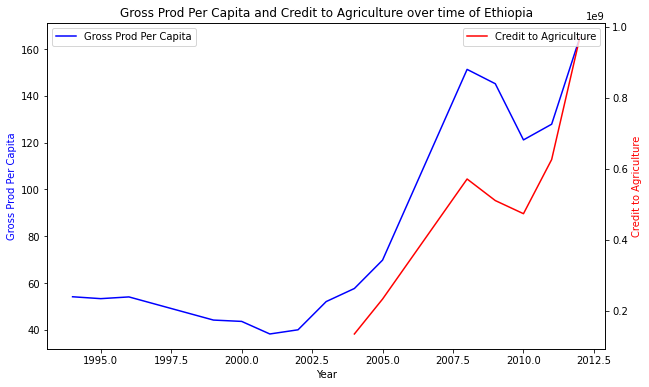

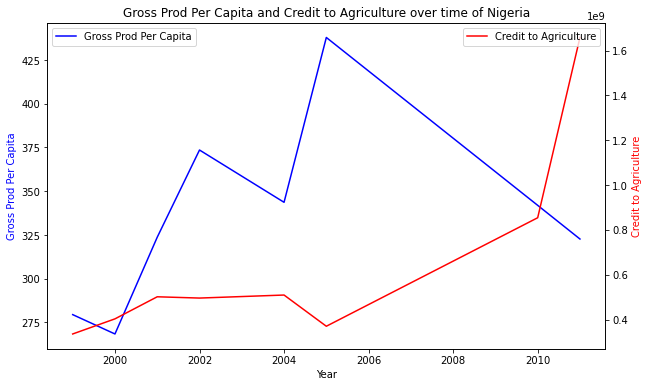

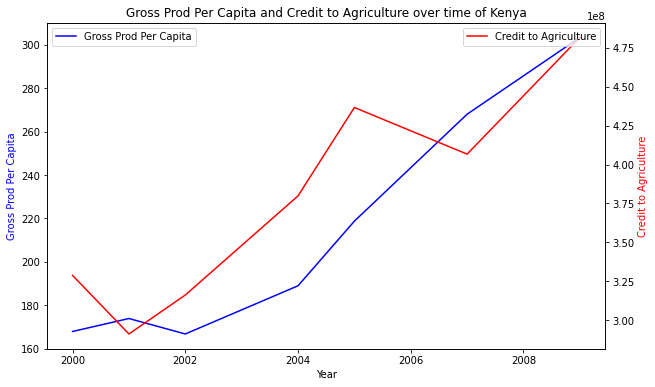

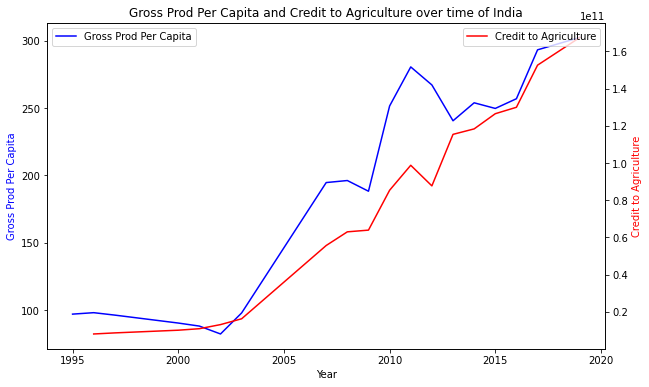

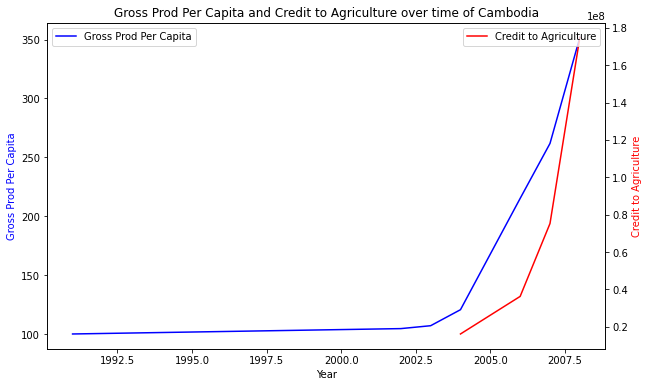

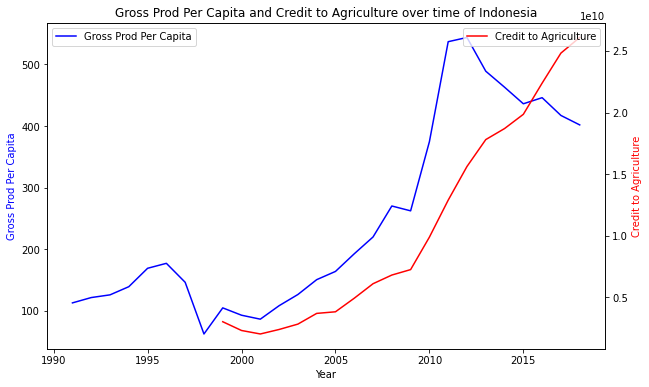

In [157]:
#Plot for under-producing countries
for country in countries_group2:
    plot_dual_chart('Credit to Agriculture', country)

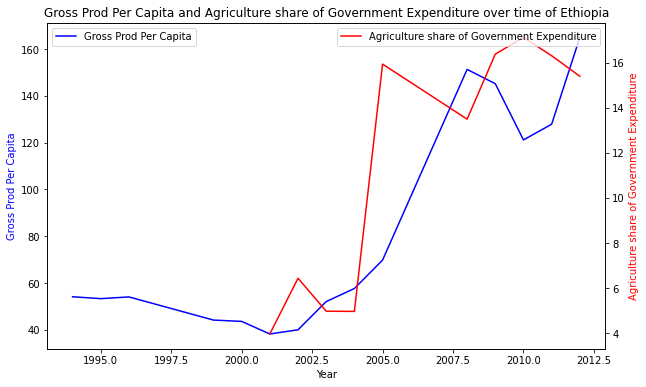

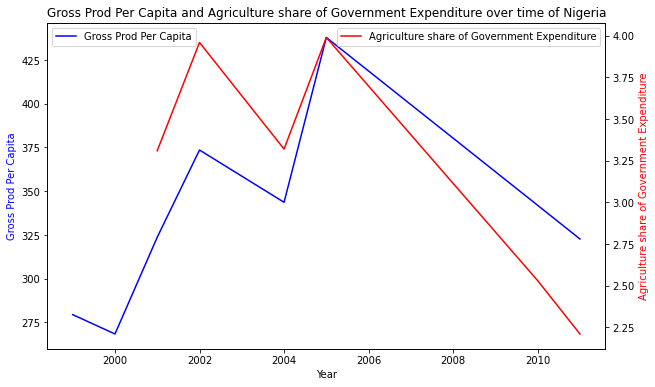

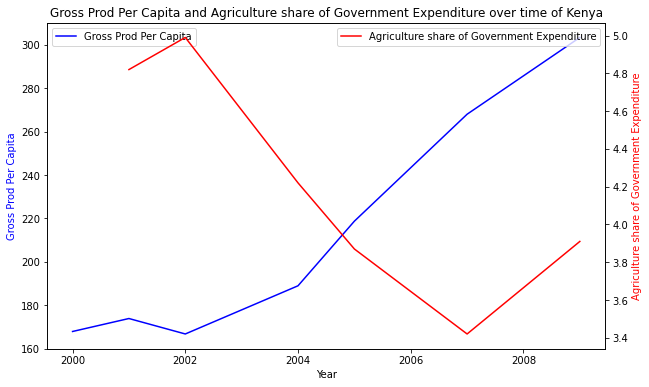

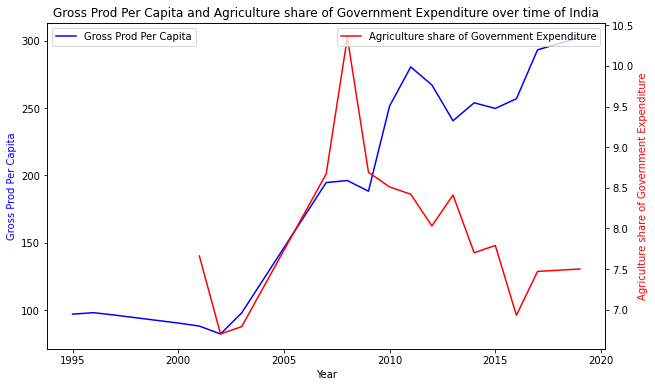

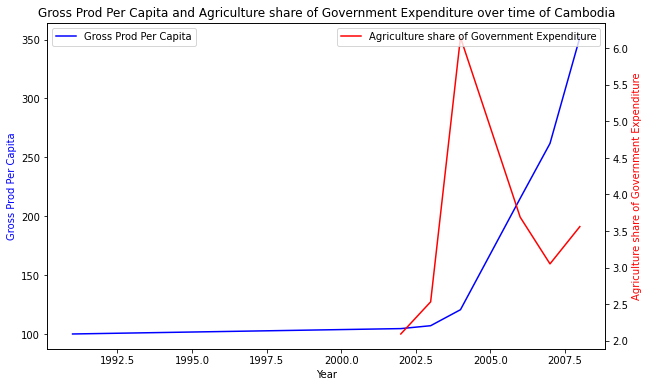

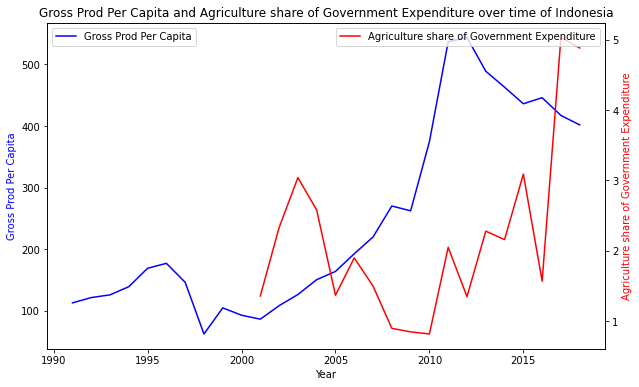

In [158]:
for country in countries_group2:
    plot_dual_chart('Agriculture share of Government Expenditure', country)

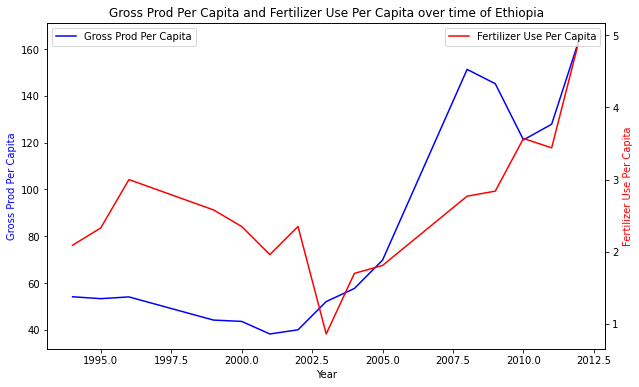

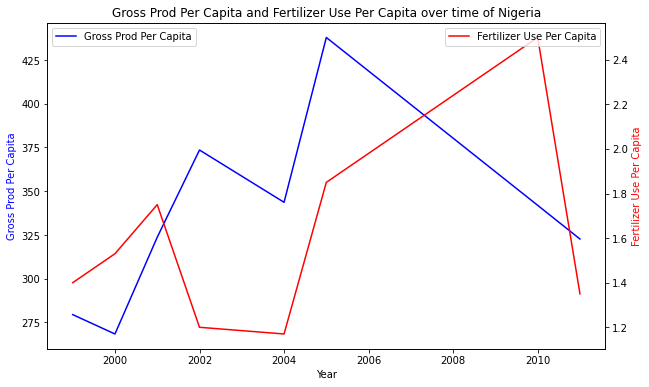

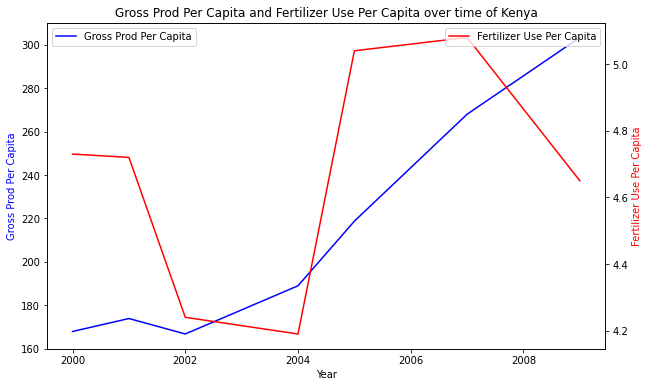

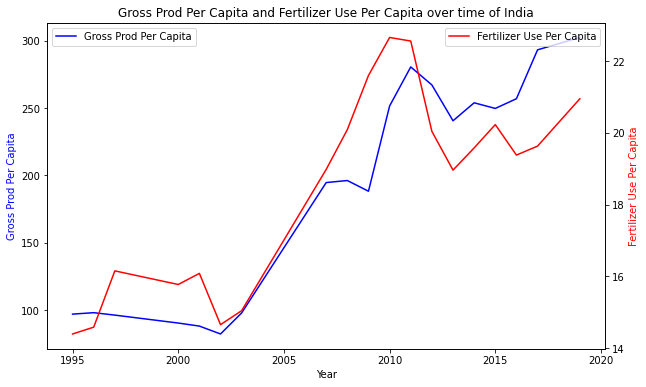

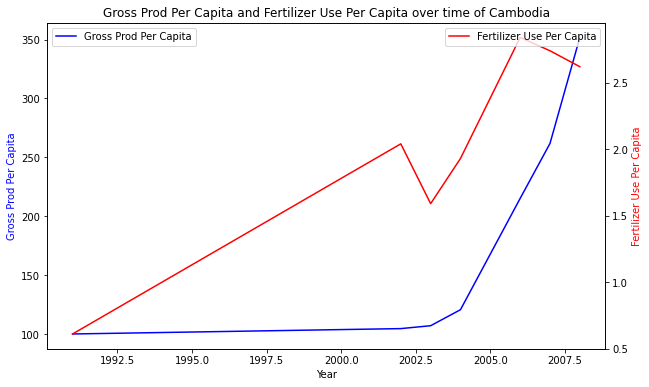

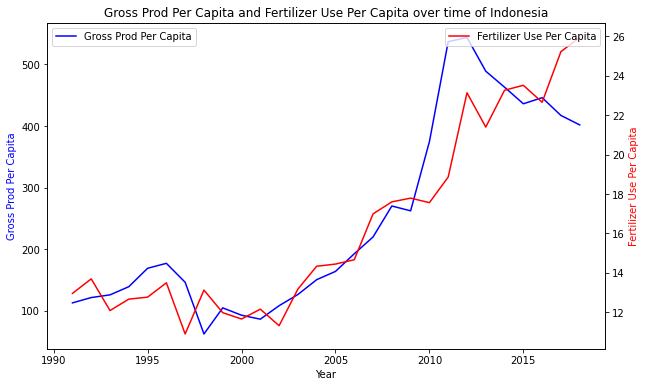

In [160]:
for country in countries_group2:
    plot_dual_chart('Fertilizer Use Per Capita', country)

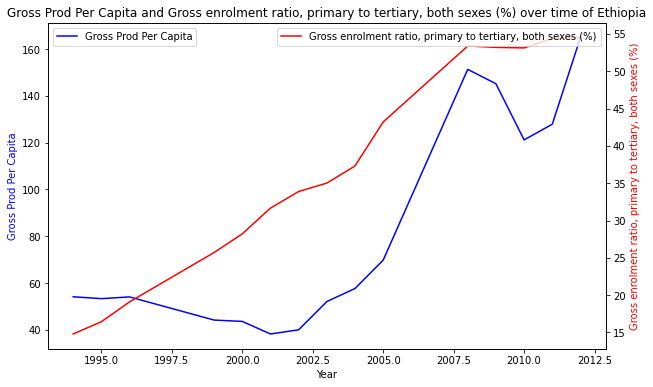

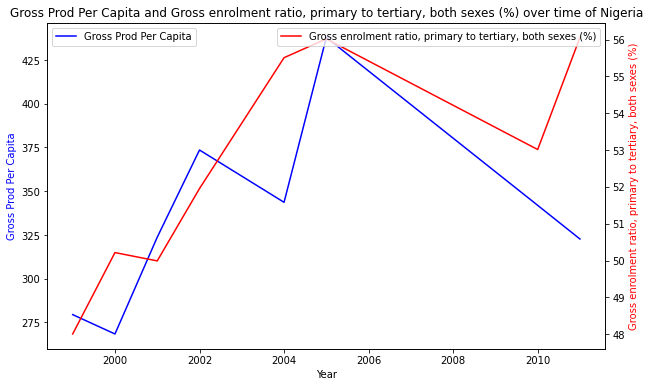

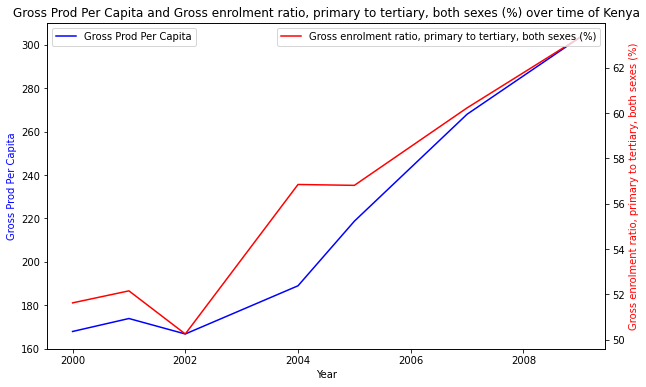

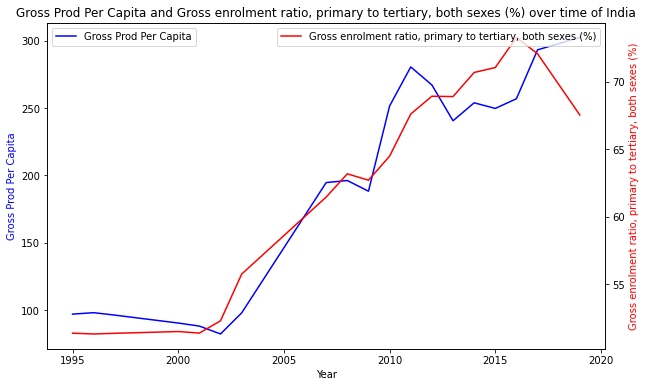

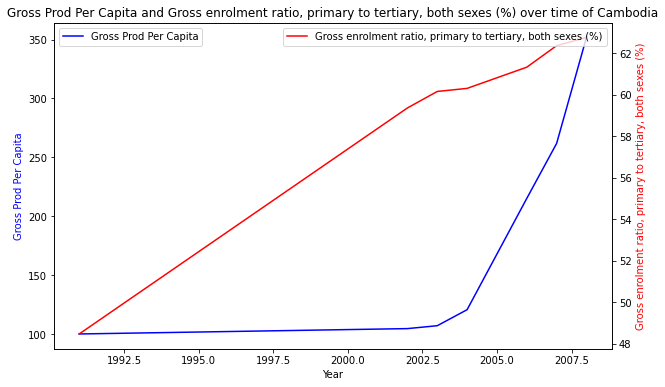

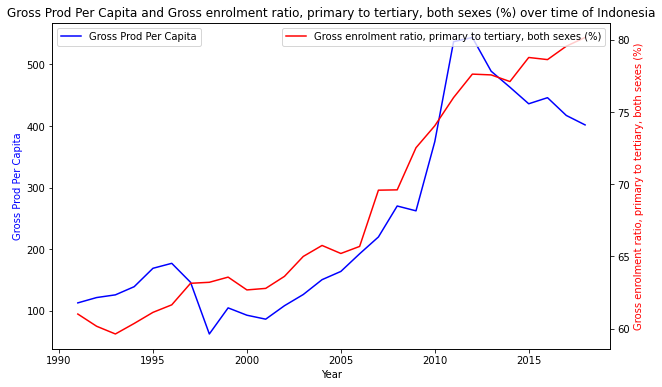

In [161]:
for country in countries_group2:
    plot_dual_chart('Gross enrolment ratio, primary to tertiary, both sexes (%)', country)

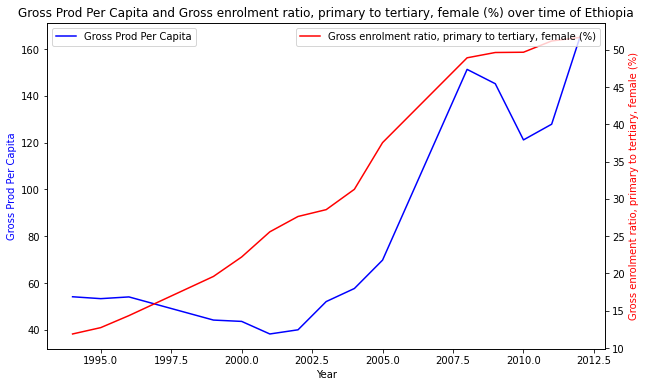

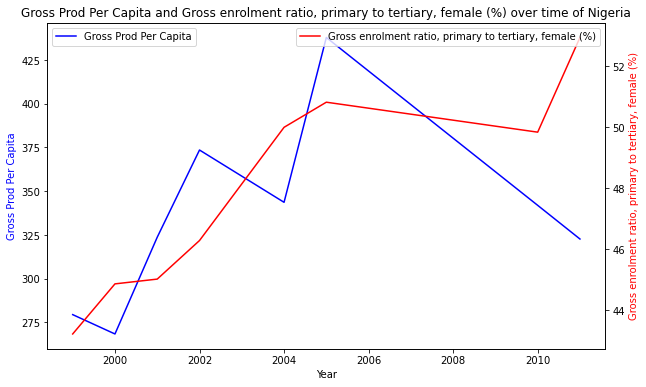

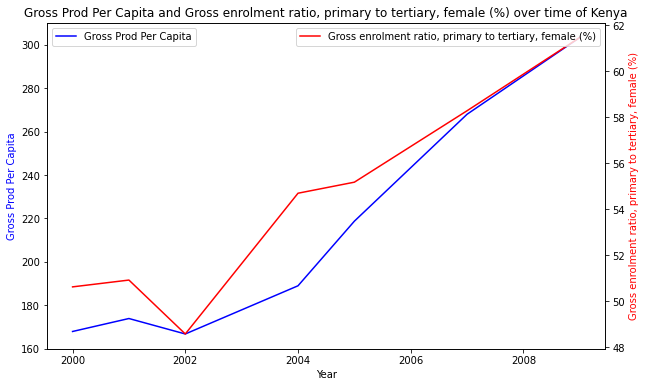

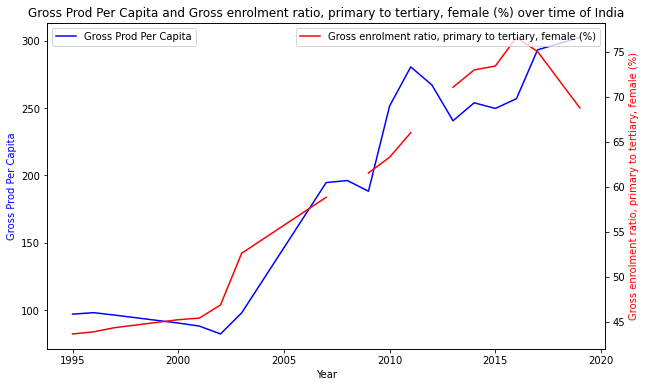

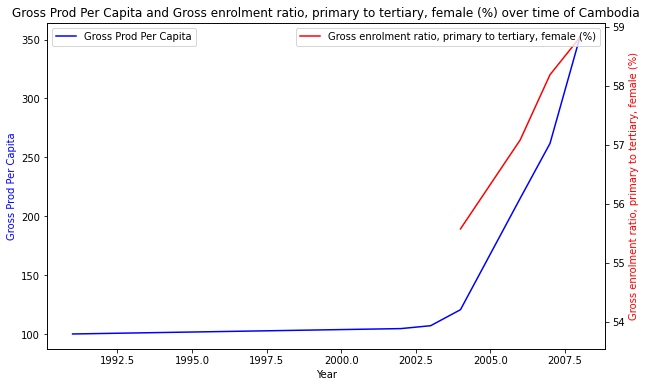

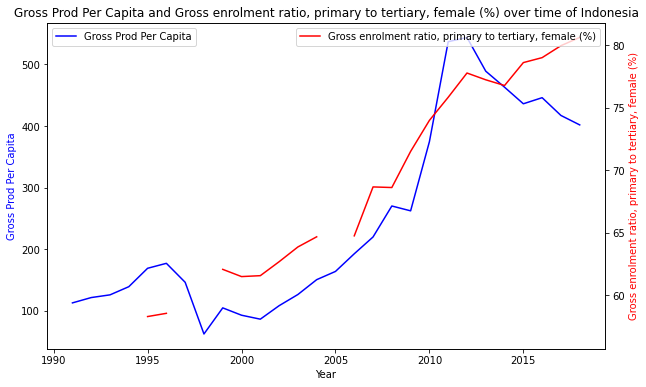

In [162]:
for country in countries_group2:
    plot_dual_chart('Gross enrolment ratio, primary to tertiary, female (%)', country)

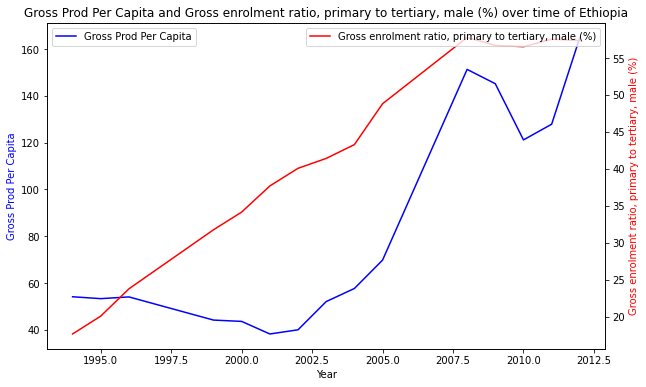

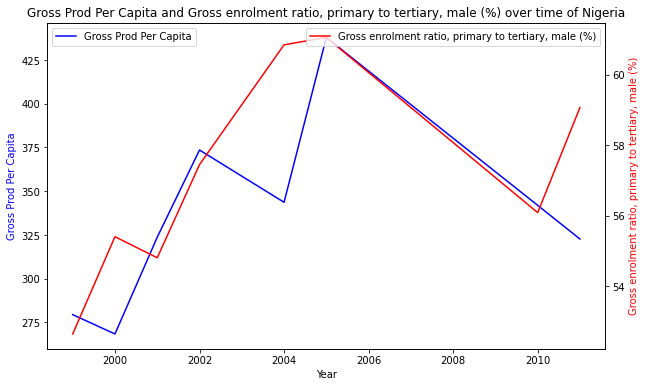

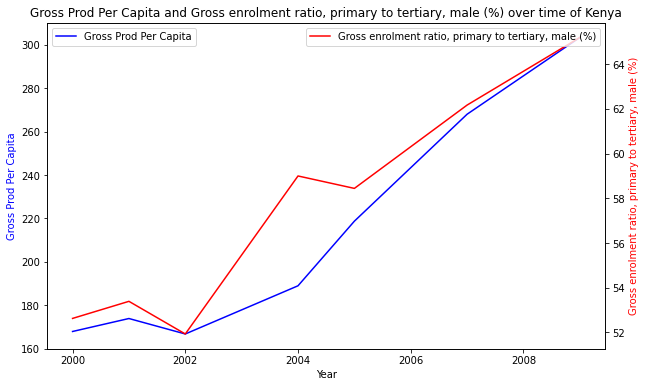

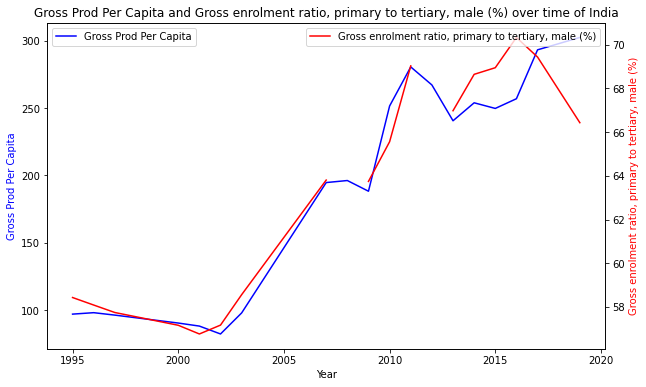

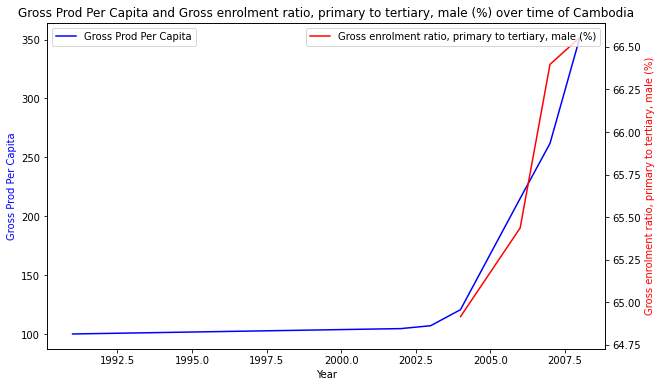

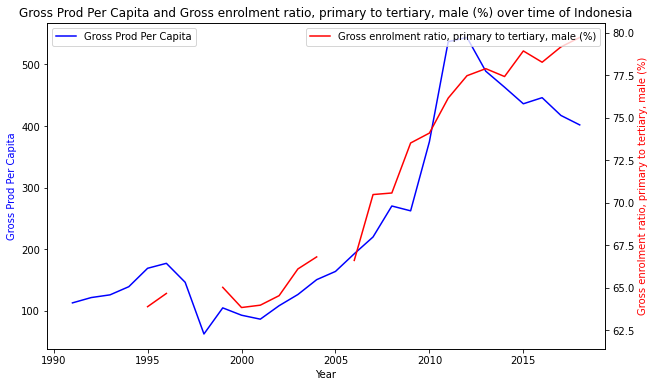

In [163]:
for country in countries_group2:
    plot_dual_chart('Gross enrolment ratio, primary to tertiary, male (%)', country)

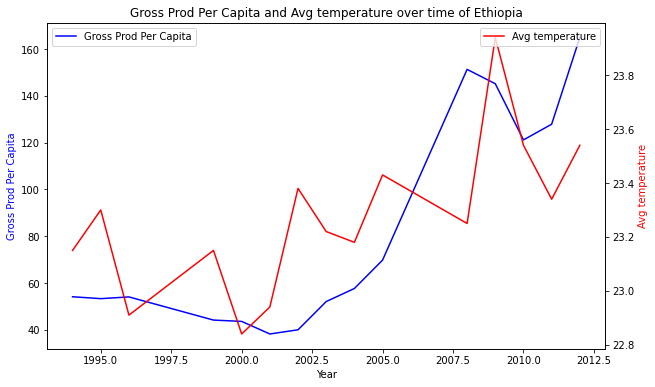

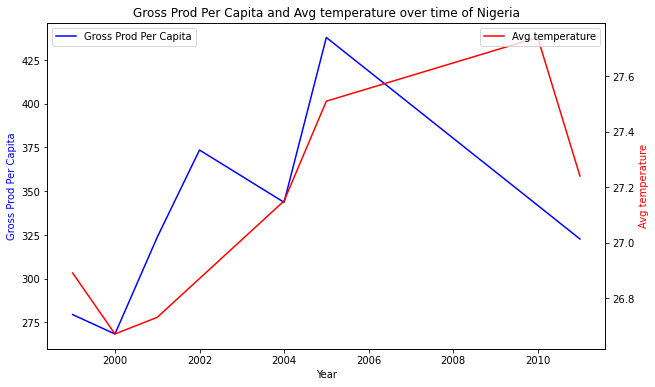

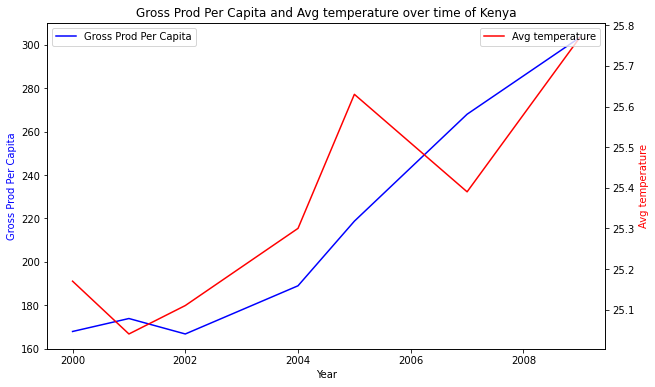

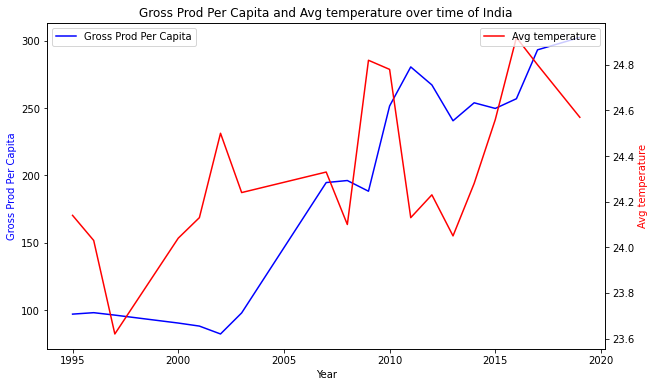

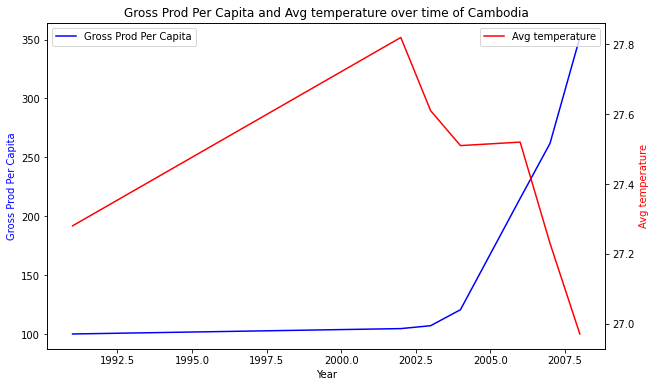

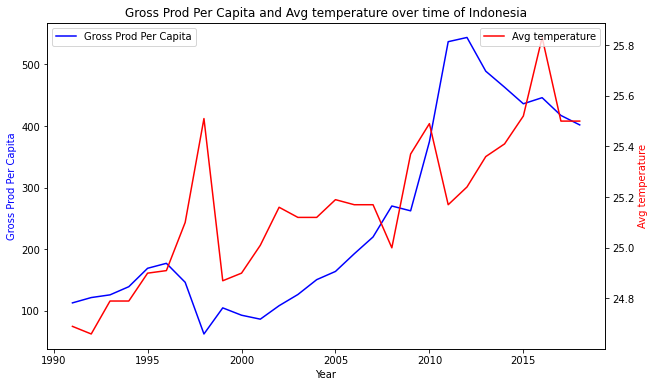

In [164]:

for country in countries_group2:
    plot_dual_chart('Avg temperature', country)